Le but de ce projet est d'utiliser un réseaux de neurones à convolution (CNN) pour appliquer un transfert de style artistique sur des photos quelconque. L'idée est donc de prendre un tableau d'un peintre célèbre, d'utiliser un les premières couches d'un CNN pour 'capturer' son style et d'appliquer une transformation sur une autre photo pour lui appliquer ce style.

Ce projet s'inspire en grande partie d'un article https://arxiv.org/abs/1508.06576, qui démontre comment les réseaux de neurones peuvent être utilisé pour appliquer un transfert de style d'une image à une autre.

## Prétraitement des images 
On commence par télécharger toutes les dépendences et les librairies nécessaires à l'implémentation de ce projet. Heureusement, nous pouvons utiliser ces modules à disposition pour grandement alléger la quantité de code à écrire. Nous utilisons ici Keras, une API de deep learning qui permet de créer des modèles de façon rapide et robuste. 

In [1]:
from __future__ import print_function

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
tf.compat.v1.disable_eager_execution()

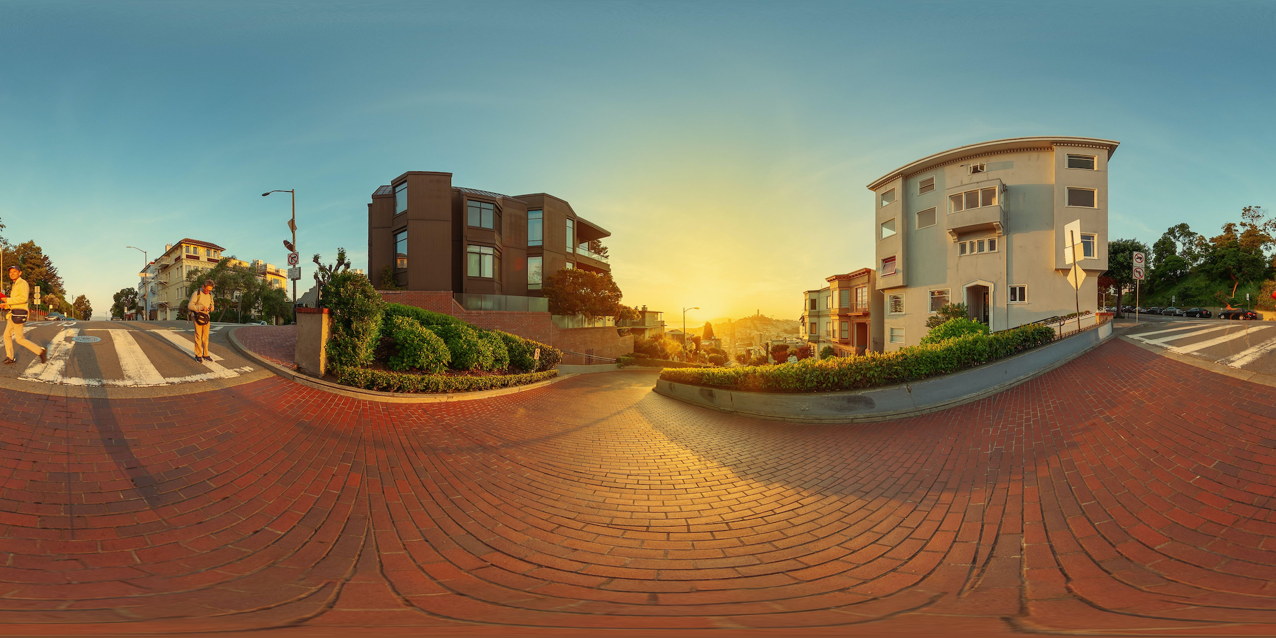

In [5]:
#Lets start loading images - image of myself
height = 638
width = 1276

path_img = '/content/gdrive/My Drive/Colab Notebooks/tests/ok_lombard_street.jpeg'
img = Image.open(path_img)
img = img.resize((width, height))
final_img = img.copy()
final_img

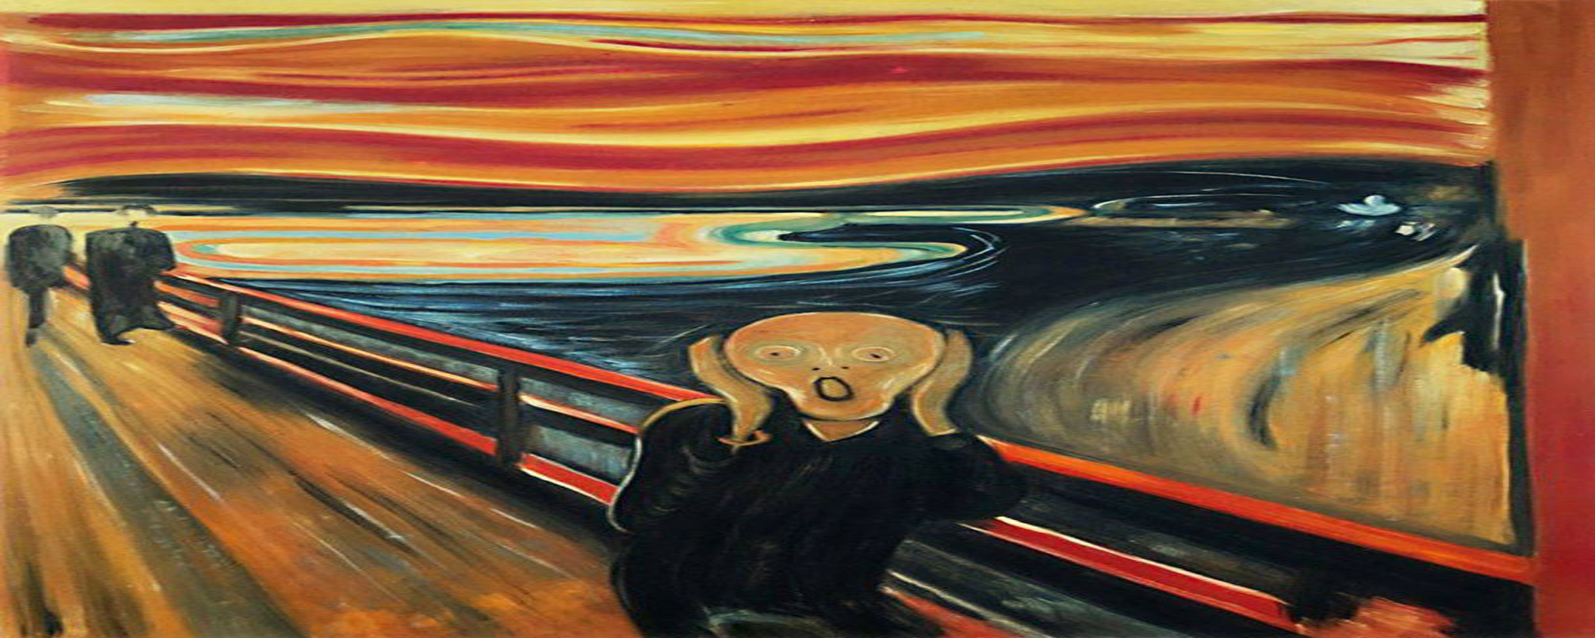

In [6]:
#Style image
style_path_img = '/content/gdrive/My Drive/Colab Notebooks/tests/van_gogh_scream.jpg'
name_style = style_path_img.split('/')[-1]

style_img = Image.open(style_path_img)
style_img = style_img.resize((width+2*width//8, height))
final_style_img = style_img.copy()
final_style_img

On procède maintenant à un prétraitement des images pour qu'elles soient véritablement exploitables par les algorithmes et modèles de Keras. On rajoute une dimension en plus qui nous permettra de concaténer les images dans une structure de donnée commune par la suite. On effecute deux transformations de suite aux images (nous ne les détaillons pas par souci de breveté).

On s'assure aussi que les images puissent être des panoramas 360°. Pour cela, on ajoute des bordures aux quatres côtés de l'image et on les enleveras ensuite.

Initial content image shape: (1, 638, 1276, 3)
style image shape: (1, 638, 1595, 3)
Final content image shape: (1, 638, 1595, 3)


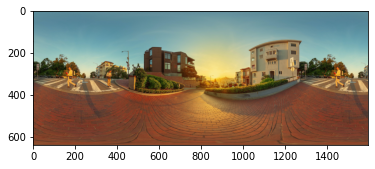

In [7]:
#Convert images to a form our APIs can handle
content_array = np.array(final_img, dtype='float64')
content_array = np.expand_dims(final_img, axis=0).copy().astype('float64')
print(f'Initial content image shape: {content_array.shape}')

style_array = np.array(final_style_img, dtype='float64')
style_array = np.expand_dims(final_style_img, axis=0).copy().astype('float64')
print(f'style image shape: {style_array.shape}')

#Add copied borders that we will clip at the end to keep coherence of 360° panoramas
left_content = content_array[:, :, :width//8, :]
right_content = content_array[:, :, width*7//8:, :]

content_array = np.concatenate((content_array, left_content), axis=2)
content_array = np.concatenate((right_content, content_array), axis=2)
print(f'Final content image shape: {content_array.shape}')
plt.imshow(content_array[0, :, :, :].astype('uint8'))
plt.show()

In [8]:
# Preprocessing
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [9]:
initial_width = width
width = width + 2*width//8

In [10]:
#Introduce placeholder to store the final combination of original image and style
content_image = backend.variable(content_array)
style_image =  backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

#Tensor that can be processed by the VGG16 model - this is why we had added extra dimension
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

Nous avons donc pour l'instant un tenseur qui contient l'image de départ (la photo), l'image de style (Monet) et un 'placeholder' qui deviendra par la suite l'image stylisée. Nous pouvons commencer à appliquer des modèles de deep learning pour le transfert de style artistique.

## Utilisation d'un modèle pré-entraîné - prolème d'optimisation

L'idée est que les CNNs pré-entraîné pour effectuer de la classification d'image savent encoder de l'information perceptuelle avec un degré d'abstraction élevé. On utilise donc l'espace des features d'un modèle pré-entraîné pour travailler sur le style et le contenu de la photo.

On utilise les premières couches du modèle VGG16 car on a pas besoin des dernières couches qui ne servent pas à représenter l'image par des caractéristiques abstraites mais qui servent à résoudre le problème de classification à proprement parler.

On pose ensuite le problème de transfert de style comme un problme d'optimisation. La fonction de coût à minimiser est décomposée en trois parties, la perte de contenu, la perte de style et la variation totale. L'importance relative des trois termes est fixée arbitrairement, pour que le résultat final soit plaisant à regarder.

In [11]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False) #No fully-connected top layer


58892288/58889256 [==============================] - 1s 0us/step


In [12]:
content_weight = 0.010
style_weight = 100.0
total_variation_weight = 1.0

In [13]:
loss = backend.variable(0.)

In [14]:
#First part of loss function - content
def content_loss(content, combination):
    """
    This function computes the euclidian distance between the original content image
    and the combination image.
    """
    return backend.sum(backend.square(combination - content))

layer_features = model.get_layer('block2_conv2').output
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [15]:
loss = loss + content_weight*content_loss(content_image_features, combination_features)

Pour la partie de la fonction de coût qui concerne le style. La simple distance euclidienne ne fait pas l'affaire. En effet, on cherche à capturer le 'style' de Monet. Si on définissait simplement une fonciton de coût pour le style avec une distance euclidienne on obtiendrait un simple mélange des deux images mais pas un transfert de ce que l'on pourrait appeler 'style'. Ainsi, on définit la matrice de Gram qui regroupe des termes de covariance entre les différentes features de la couche choisie du réseau de neurones. Cette matrice comprend donc de l'information vis à vis de quelles features s'activent ensemble, c'est donc invariant par rapport à larrangement spécifique d'objet dans l'image de style mais cela capture des statistiques aggrégées sur l'image entière (ce qui constitue le 'style').

In [16]:
#Second part of loss function - style loss
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
    
def style_loss(style, combination):
    """
    This function computes the frobenius distance between the gram matrices of style and 
    combination image.
    """
    style_gram = gram_matrix(style)
    combination_gram = gram_matrix(combination)
    channels = 3
    size = height*width
    return backend.sum(backend.square(style_gram - combination_gram)) / (4. * (channels**2) * (size**2))

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = model.get_layer(layer_name).output
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
    

On calcule maintenant la variation totale, la troisième partie de notre fonction coût à minimiser. Ceci correspond à un terme régularisateur.

In [17]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_image)

### On résoût le problème d'optimisation
C'est parti!

In [18]:
grads = backend.gradients(loss, combination_image)

In [19]:
outputs = [loss]
outputs = outputs + grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [20]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 100

for i in range(iterations):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)

Start of iteration 0
Current loss value: 1668279800000.0
Start of iteration 1
Current loss value: 374263480000.0
Start of iteration 2
Current loss value: 193900170000.0
Start of iteration 3
Current loss value: 143510620000.0
Start of iteration 4
Current loss value: 115663010000.0
Start of iteration 5
Current loss value: 96638200000.0
Start of iteration 6
Current loss value: 85077230000.0
Start of iteration 7
Current loss value: 76634270000.0
Start of iteration 8
Current loss value: 69879570000.0
Start of iteration 9
Current loss value: 63992440000.0
Start of iteration 10
Current loss value: 59805840000.0
Start of iteration 11
Current loss value: 56656306000.0
Start of iteration 12
Current loss value: 53471160000.0
Start of iteration 13
Current loss value: 50652455000.0
Start of iteration 14
Current loss value: 48355660000.0
Start of iteration 15
Current loss value: 46200460000.0
Start of iteration 16
Current loss value: 44491133000.0
Start of iteration 17
Current loss value: 4282921000

In [21]:
x_copy = x.copy()

(638, 1595, 3)


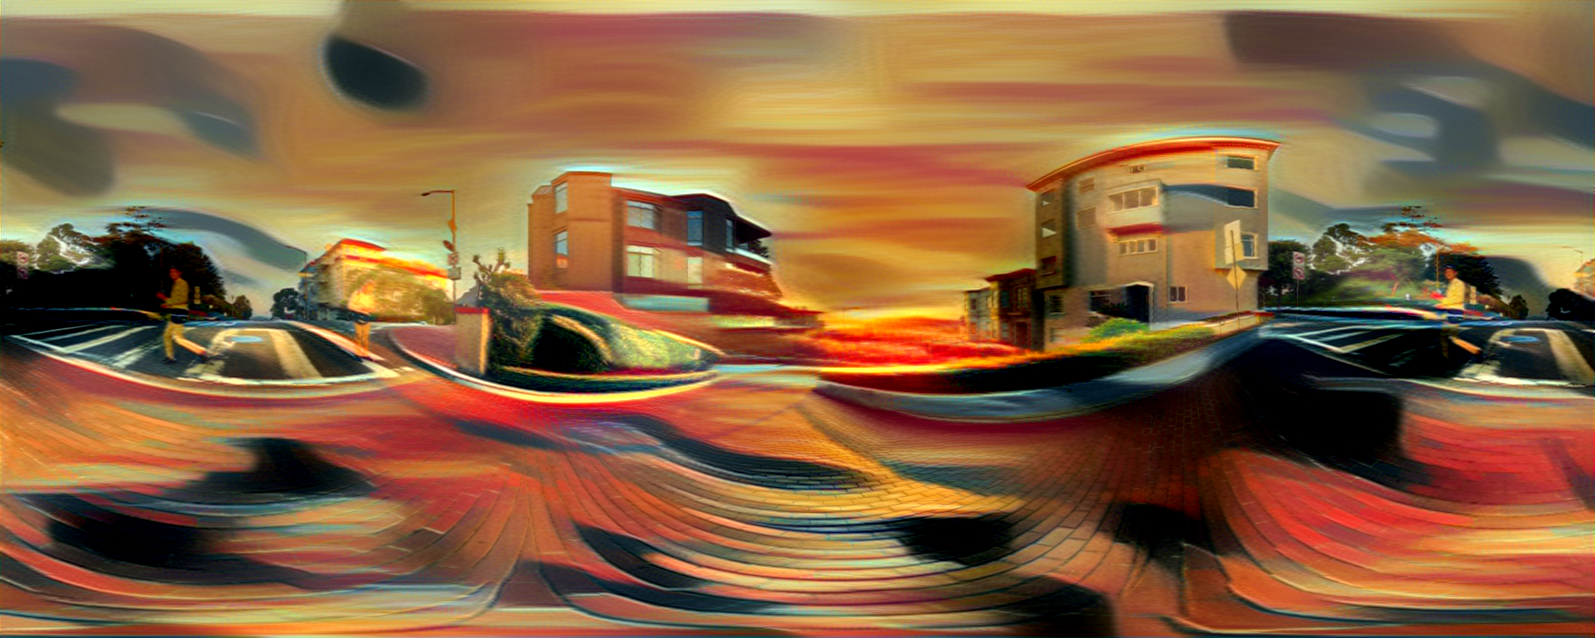

In [22]:
x_ = x_copy.reshape((height, width, 3))
x_ = x_[:, :, ::-1]
x_[:, :, 0] += 103.939
x_[:, :, 1] += 116.779
x_[:, :, 2] += 123.68
x_ = np.clip(x_, 0, 255).astype('uint8')

print(x_.shape)
Image.fromarray(x_)

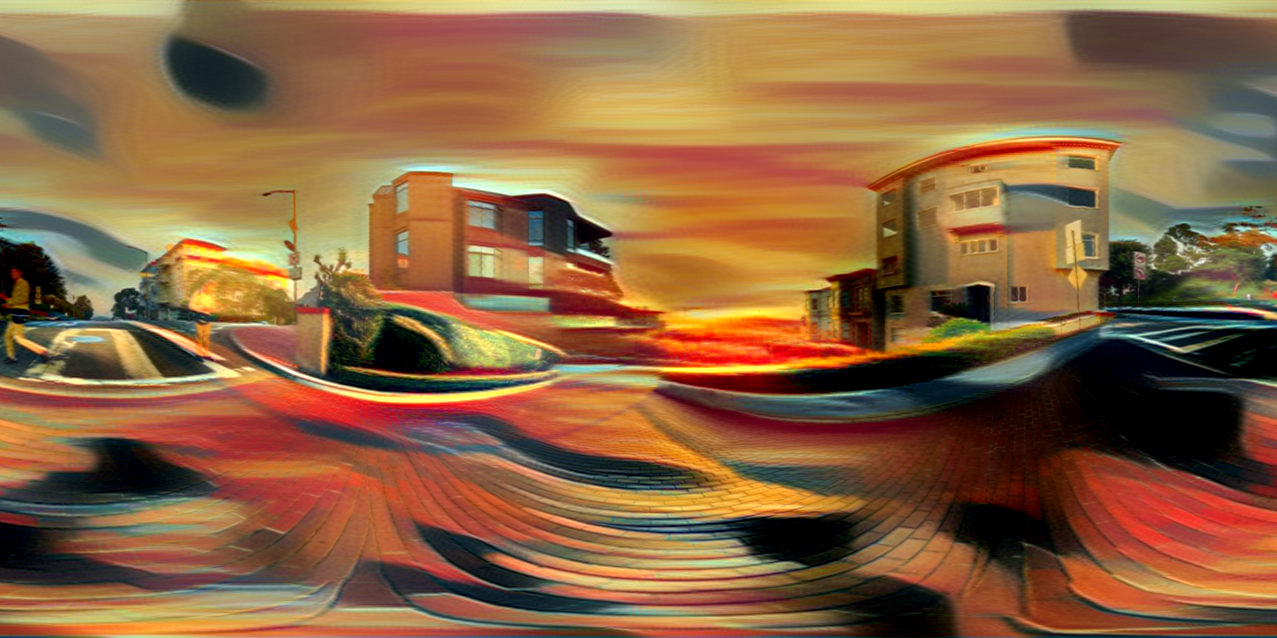

In [23]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = x[:, initial_width//8: len(x[1])- initial_width//8, :]
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [24]:

imwrite(f'/content/gdrive/My Drive/Colab Notebooks/tests/tests_to_keep/test_' + name_style, x)

In [25]:
print(name_style)
x.shape

van_gogh_scream.jpg


(638, 1277, 3)